In [37]:
import os
import json


paths=[]
labels=[]
feature_id = []
count = 0
for dirname, _, filenames in os.walk('imagenet/images/train'):
    for filename in filenames:
        if filename[-4:]=='JPEG':
            paths+=[(os.path.join(dirname, filename))]
            feature_id+=[(os.path.join(dirname, filename))[len("imagenet/images/train")+1:]]
            label=dirname.split('/')[-1]
            labels+=[label]
            if os.path.isfile("imagenet/bboxes_annotations/"+(os.path.join(dirname, filename))[len("imagenet/images/train")+1:][:-4]+"xml") == False:
                paths.pop()
                feature_id.pop()
                labels.pop()
                count += 1

print(len(paths))
            
tpaths=[]
tlabels=[]
for dirname, _, filenames in os.walk('imagenet/images/val'):
    for filename in filenames:
        if filename[-4:]=='JPEG':
            tpaths+=[(os.path.join(dirname, filename))]
            label=dirname.split('/')[-1]
            tlabels+=[label]

all_labels=os.listdir('imagenet/images/train')

print(len(all_labels))

label_map = {}
with open('ImageNet_class_index.json') as f:
    d = json.load(f)

    for i in d.values():
        label_map[i[0]] = i[1]

    print(label_map)

12982
1000
{'n01440764': 'tench', 'n01443537': 'goldfish', 'n01484850': 'great_white_shark', 'n01491361': 'tiger_shark', 'n01494475': 'hammerhead', 'n01496331': 'electric_ray', 'n01498041': 'stingray', 'n01514668': 'cock', 'n01514859': 'hen', 'n01518878': 'ostrich', 'n01530575': 'brambling', 'n01531178': 'goldfinch', 'n01532829': 'house_finch', 'n01534433': 'junco', 'n01537544': 'indigo_bunting', 'n01558993': 'robin', 'n01560419': 'bulbul', 'n01580077': 'jay', 'n01582220': 'magpie', 'n01592084': 'chickadee', 'n01601694': 'water_ouzel', 'n01608432': 'kite', 'n01614925': 'bald_eagle', 'n01616318': 'vulture', 'n01622779': 'great_grey_owl', 'n01629819': 'European_fire_salamander', 'n01630670': 'common_newt', 'n01631663': 'eft', 'n01632458': 'spotted_salamander', 'n01632777': 'axolotl', 'n01641577': 'bullfrog', 'n01644373': 'tree_frog', 'n01644900': 'tailed_frog', 'n01664065': 'loggerhead', 'n01665541': 'leatherback_turtle', 'n01667114': 'mud_turtle', 'n01667778': 'terrapin', 'n01669191': '

In [2]:
from torchvision.transforms import v2 as T
import random

# /Users/ronaksingh/Documents/Github/NGHackathon24/imagenet/bboxes_annotations/n04107743/n00141669_73.xml

def get_transform(train):
    transforms = []
    if train:
        # transforms.append(T.RandomResizedCrop(size=(224, 224), antialias=True))
        # transforms.append(T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)))
        # transforms.append(T.RandomPhotometricDistort(0.5))
        transforms.append(T.RandomHorizontalFlip(1))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [3]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
import xml.etree.ElementTree as ET
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader
from torchvision import datasets

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


# labelsMaster = ["bg", "Musical keyboard", "Piano", "Wheel", "Car", "Mirror", "Clothing", "Chair", "Ladder", "Music stand", "Table", "Chair", "Building (group)", "Drink (group)", "Shelf", "Book", "Book (group)", "Camera", "Drink", "Desk", "Human arm", "Human hair", "Human leg", "Human hand", "Watch", "Screen", "Woman"]


def read_pascal_voc_annotation(xml_file):
    # tree = ET.parse(xml_file, parser = ET.XMLParser(encoding = 'iso-8859-5'))
    # print(xml_file)
    tree = ET.parse(xml_file)

    root = tree.getroot()

    annotations = []
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)
        label = obj.find('name').text

        annotations.append({
            'bbox': [xmin, ymin, xmax, ymax],
            'label': label
        })

    return annotations

# print(read_pascal_voc_annotation('../imagenet/bboxes_annotations/n01440764/n01440764_1775.xml'))

# imagenet_train = ImageNet(root="../imagenet/images/train/", split='train', transform=get_transform(train=True))


class ImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = paths
        self.annotations = feature_id
        # self.annotations = ann_paths

    def __getitem__(self, idx):
        # load images and masks
        # img_path = os.path.join(self.root, "JPGImages", self.imgs[idx])
        # annotation_path = os.path.join(self.root, "Annotations", self.annotations[idx])
        img_path = self.imgs[idx]
        annotation_path = os.path.join(self.root, "bboxes_annotations", (self.annotations[idx][:-4]+"xml"))
        img = read_image(img_path)

        # print(img_path)
        
        annotation_out = read_pascal_voc_annotation(annotation_path)

        # instances are encoded as different colors
        # obj_ids = torch.unique(img)
        # first id is the background, so remove it
        # obj_ids = obj_ids[1:]
        num_objs = len(annotation_out)

        # print(num_objs)

        # split the color-encoded mask into a set
        # of binary masks
        # masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        # boxes = masks_to_boxes(masks)
        # boxesList = [a["bbox"] for a in annotation_out]
        boxesList = []
        # boxes = torch.tensor(np.array(boxesList), dtype=float)

        # there is only one class
        # labels = torch.ones((num_objs,), dtype=torch.int64)

        # labelList = [labelsMaster.index(a["label"]) for a in annotation_out]

        # labelList = [labels.index(a["label"]) for a in annotation_out]
        labelList = []

        for a in annotation_out:
            if a["label"] in all_labels:
                labelList += [all_labels.index(a["label"])+1]
                boxesList += [a["bbox"]]

        boxes = torch.tensor(np.array(boxesList), dtype=float)
        
        tensorLabel = torch.tensor(np.array(labelList), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["labels"] = tensorLabel
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        # print(target["boxes"].long())

        # image = (255.0 * (img - img.min()) / (img.max() - img.min())).to(torch.uint8)
        # image = image[:3, ...]
        # pred_labels = [f"{label}" for label in target["labels"]]
        # # pred_labels = [f"person"]
        # pred_boxes = target["boxes"].long()
        # output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")
        # # print(output_image)

        # # plt.figure(figsize=(12, 12))
        # plt.imshow(output_image.permute(1, 2, 0))

        # print(target["boxes"])

        if self.transforms is not None:
            # if random.random() > 0.5:
                img, target["boxes"] = self.transforms(img, target["boxes"])

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.score_thresh = 0

    return model

model = get_model_instance_segmentation(len(all_labels)+1)

tensor([0.6288, 0.3412, 0.3290, 0.2039, 0.1737, 0.1628, 0.1493, 0.1111, 0.1060,
        0.1026, 0.0773, 0.0695, 0.0553, 0.0484, 0.0411, 0.0390, 0.0354, 0.0296,
        0.0288, 0.0270, 0.0161, 0.0152, 0.0140, 0.0131, 0.0125, 0.0119, 0.0115,
        0.0111, 0.0104, 0.0096, 0.0096, 0.0093, 0.0092, 0.0086, 0.0080, 0.0077,
        0.0077, 0.0075, 0.0057, 0.0051, 0.0051, 0.0041, 0.0035, 0.0033, 0.0033,
        0.0032, 0.0031, 0.0024, 0.0024, 0.0023, 0.0021, 0.0021, 0.0021, 0.0019,
        0.0019, 0.0018, 0.0018, 0.0017, 0.0017, 0.0017, 0.0017, 0.0016, 0.0016,
        0.0016, 0.0016, 0.0016, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012])
tensor([0.9990, 0.9837, 0.8599, 0.6734, 0.6001, 0.5274, 0.3556, 0.2826, 0.2191,
        0.1376, 0.1301,

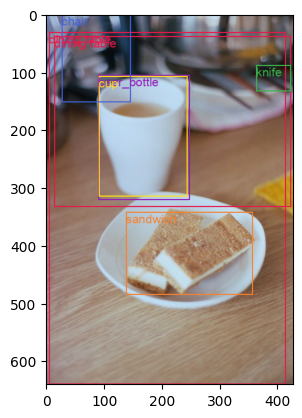

In [82]:
import matplotlib.pyplot as plt
import torch
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from PIL import Image, ImageFont, ImageDraw 
import torchvision.transforms.functional as F
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

pretrainedModel = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

pretrainedModel.eval()

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']*10

coco_names = ["person" , "bicycle" , "car" , "motorcycle" , "airplane" , "bus" , "train" , "truck" , "boat" , "traffic light" , "fire hydrant" , "street sign" , "stop sign" , "parking meter" , "bench" , "bird" , "cat" , "dog" , "horse" , "sheep" , "cow" , "elephant" , "bear" , "zebra" , "giraffe" , "hat" , "backpack" , "umbrella" , "shoe" , "eye glasses" , "handbag" , "tie" , "suitcase" , "frisbee" , "skis" , "snowboard" , "sports ball" , "kite" , "baseball bat" , "baseball glove" , "skateboard" , "surfboard" , "tennis racket" , "bottle" , "plate" , "wine glass" , "cup" , "fork" , "knife" , "spoon" , "bowl" ,  "banana" , "apple" , "sandwich" , "orange" , "broccoli" , "carrot" , "hot dog" , "pizza" , "donut" , "cake" , "chair" , "couch" , "potted plant" , "bed" , "mirror" , "dining table" , "window" , "desk" , "toilet" , "door" , "tv" , "laptop" , "mouse" , "remote" , "keyboard" , "cell phone" , "microwave" , "oven" , "toaster" , "sink" , "refrigerator" , "blender" , "book" ,"clock" , "vase" , "scissors" , "teddy bear" , "hair drier" , "toothbrush" , "hair brush"]


# image = read_image("PennFudanPed/PNGImages/PennPed00096.png")

# CHANGE THIS PATH TO CHANGE THE INPUT IMAGE
image = read_image("Images/image11.jpg")
h, w = F.get_image_size(image)
eval_transform = get_transform(train=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_model_instance_segmentation(1001)
model.load_state_dict(torch.load("ronak_learning/imagenet_finetune_fix_25.pth", weights_only=True, map_location=torch.device('cpu')))
model.eval()

with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    # print(x)
    predictions = model([x, ])
    pretrainedPred = pretrainedModel([x, ])
    print(predictions[0]["scores"])
    print(pretrainedPred[0]["scores"])
    predRaw = predictions[0]
    predRaw2 = pretrainedPred[0]

idxOfClass = [i for i, x in enumerate(list(predRaw['scores'])) if x >= 0.6]
idxOfClass2 = [i for i, x in enumerate(list(predRaw2['scores'])) if x >= 0.5]
# print(idxOfClass)
# pred = {'boxes': predRaw['boxes'][idxOfClass],'labels': predRaw['labels'][idxOfClass],'masks': predRaw['masks'][idxOfClass],'scores': predRaw['scores'][idxOfClass]}

pred = {'boxes': predRaw['boxes'][idxOfClass],'labels': predRaw['labels'][idxOfClass],'scores': predRaw['scores'][idxOfClass]}
pred2 = {'boxes': predRaw2['boxes'][idxOfClass2],'labels': predRaw2['labels'][idxOfClass2],'scores': predRaw2['scores'][idxOfClass2]}


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
print(pred["labels"], len(all_labels))
pred_labels = [f"{label_map[all_labels[label-1]]}" for label, score in zip(pred["labels"], pred["scores"])]
# pred_labels2 = [f"{coco_names[label2-1]}: {score2:.3f}" for label2, score2 in zip(pred2["labels"], pred2["scores"])]
pred_labels2 = [f"{coco_names[label2-1]}" for label2, score2 in zip(pred2["labels"], pred2["scores"])]


comb_labels = pred_labels + pred_labels2

unique_labels = list(set(comb_labels))

used_colors = colors[:len(unique_labels)]
final_colors = []

for i in comb_labels:
    final_colors.append(used_colors[unique_labels.index(i)])

pred_boxes = pred["boxes"].long()
pred_boxes2 = pred2["boxes"].long()

comb_boxes = torch.cat((pred_boxes, pred_boxes2), 0)

print(comb_labels)

# output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")
# output_image = draw_bounding_boxes(image, comb_boxes, comb_labels, colors=final_colors, width=5, font="Arial.tff", font_size=30)

box_width = max(2, int(h * 0.005))

image_with_boxes = draw_bounding_boxes(image, comb_boxes, colors=final_colors, width=box_width)

image_with_boxes = F.to_pil_image(image_with_boxes)
font_size = max(10, int(h * 0.05))
font = ImageFont.truetype('Arial.ttf', font_size)

draw = ImageDraw.Draw(image_with_boxes)
for box, label, color in zip(comb_boxes, comb_labels, final_colors):
    x, y = box[:2]  # top-left corner for the text
    draw.text((x, y), label, fill=color, font=font)

plt.imshow(image_with_boxes)
# plt.axis("off")
# plt.show()

# plt.figure(figsize=(12, 12))
# plt.imshow(output_image.permute(1, 2, 0))